In [1]:
import numpy as np
import astropy.units as u
import sbpy.activity as sba
import matplotlib.pyplot as plt
from sbpy.data import Phys
from astropy.visualization import quantity_support

# Applying the vectorial model included in sbpy.activity

The vectorial model implemented here is described in [Festou 1981](https://ui.adsabs.harvard.edu/abs/1981A%26A....95...69F) and incorporated as a derived class of GasComa in [`sbpy.activity.gas`]() that serves as an alternative to the Haser model ([Haser 1957](https://ui.adsabs.harvard.edu/abs/1957BSRSL..43..740H/abstract), [Haser 2020](https://iopscience.iop.org/article/10.3847/PSJ/abc17b/meta)) to obtain the density distribution of neutral fragments produced by the photodissociation of parent molecules.

# Input parameters

### Parent and fragment data
The model supports two methods of specifying the parent production and its time dependence, both of which are covered below.  The observation time of the model is always at t = 0, and positive time values indicate farther into the past.

We begin by specifying some physical details about our parent and fragment molecules.
In our example calculations, the parent and fragment molecules are H2O and OH respectively:

In [5]:
# Rough parameters for a quick example calculation

# Parent molecule is H2O
parent_species = Phys.from_dict({
    # Total lifetime: will be smaller due to other sources of destruction, but this multiplicative
    # factor is approximate
    'tau_T': sba.photo_timescale('H2O') * 0.8,
    # Dissociative lifetime
    'tau_d': sba.photo_timescale('H2O'),
    # Outflow velocity, taken from Cochran and Schleicher, 1993
    'v_outflow': 0.85 * u.km/u.s,
    # Approximate cross section
    'sigma': 3e-16 * u.cm**2
    })

# Fragment is OH
fragment_species = Phys.from_dict({
    # Total lifetime: Again, factor of 0.8 is approximate
    'tau_T': sba.photo_timescale('OH') * 0.8,
    # Velocity after dissociation, taken from Cochran and Schleicher, 1993
    'v_photo': 1.05 * u.km/u.s
    })

print(parent_species)
print(fragment_species)

<QTable length=1>
 tau_T   tau_d  v_outflow  sigma 
   s       s      km / s    cm2  
float64 float64  float64  float64
------- ------- --------- -------
41600.0 52000.0      0.85   3e-16
<QTable length=1>
 tau_T   v_photo
   s      km / s
float64  float64
-------- -------
128000.0    1.05


### Time Dependence and Production: Method 1, binned production
The first method allows for an array of steady production values, paired with the times at which they start:

In [3]:
# 30 days ago to 5 days ago, Q was 1e28
# 5 days ago to 3 days ago, Q jumps to 5e28
# 3 days ago until present, Q was 2e28
times_at_production = [30, 5, 3] * u.day
production_rates = [1.e28, 5.e28, 2.e28] * (1/u.s)

# Line below is commented out because we don't need the notebook to actually run this calculation
# coma_one = sba.VectorialModel.binned_production(qs=production_rates, parent=parent_species, fragment=fragment_species, ts=times_at_production)

Note that the first entry in the production, 1e28, will be used by the model as a base production rate, which decides things like grid size, and extends that production backward to all times further in the past.

---

### Time Dependence and Production: Method 2, arbitrary time dependence
The second method allows the specification of a constant base_q production rate and an optional time-dependent production rate q_t that is additive to the base, so that the production at any time is

    q_tot = base_q + q_t(t)

If no q_t is given, then production is assumed to be steady at base_q.

Here we construct a water production that varies sinusoidally between 1e28 and 3e28 with a period of 10 hours:

In [4]:
def make_sine_q_t(amplitude, period, delta):
    period_in_secs = period.to(u.s).value
    delta_in_secs = delta.to(u.s).value
    amp_in_invsecs = amplitude.to(1/u.s).value
    const_B = (2.0 * np.pi)/period_in_secs

    def q_t(t):
        return amp_in_invsecs * (
                np.sin(const_B*(t + delta_in_secs)) + 1
                )

    return q_t

base_q = 1e28
q_t = make_sine_q_t(1e28 * (1/u.s), 10.0 * u.hour, -2.5 * u.hour)

# Check that this is actually doing what we want
for hour in [0, 2.5, 5.0, 7.5, 10.0]*u.hour:
    print(f"Production at t = {hour} ago:\t{base_q + q_t(hour.to(u.s).value):3.2e}")

Production at t = 0.0 h ago:	1.00e+28
Production at t = 2.5 h ago:	2.00e+28
Production at t = 5.0 h ago:	3.00e+28
Production at t = 7.5 h ago:	2.00e+28
Production at t = 10.0 h ago:	1.00e+28


And we hand this off to the model:

In [5]:
coma_sine = sba.VectorialModel(base_q=base_q*(1/u.s),
                          parent=parent_species,
                          fragment=fragment_species,
                          q_t=q_t,
                          print_progress=True
                          )

# Examining the results
After the calculations are finished, the results are stored in the dictionary `vmodel` and contain information about the volume & column densities, the grids used to in the calculations, and some other things that might be useful.

## Fragment volume density

If we need to see the number density of the fragments as computed on the model's grid, we can see that here:

In [6]:
print("\n\nRadius (km) vs Fragment density (1/cm3)\n---------------------------------------")
volume_densities = list(zip(coma_sine.vmodel['radial_grid'], coma_sine.vmodel['radial_density']))
for pair in volume_densities:
    print(f'{pair[0].to(u.km):7.0f} :\t{pair[1].to(1/(u.cm**3)):5.3e}')



Radius (km) vs Fragment density (1/cm3)
---------------------------------------
    176 km :	1.506e+05 1 / cm3
    210 km :	1.271e+05 1 / cm3
    250 km :	1.074e+05 1 / cm3
    297 km :	9.092e+04 1 / cm3
    354 km :	7.706e+04 1 / cm3
    421 km :	6.539e+04 1 / cm3
    501 km :	5.555e+04 1 / cm3
    597 km :	4.725e+04 1 / cm3
    710 km :	4.028e+04 1 / cm3
    845 km :	3.443e+04 1 / cm3
   1006 km :	2.949e+04 1 / cm3
   1197 km :	2.531e+04 1 / cm3
   1424 km :	2.179e+04 1 / cm3
   1695 km :	1.881e+04 1 / cm3
   2017 km :	1.628e+04 1 / cm3
   2401 km :	1.413e+04 1 / cm3
   2857 km :	1.229e+04 1 / cm3
   3400 km :	1.071e+04 1 / cm3
   4047 km :	9.350e+03 1 / cm3
   4816 km :	8.168e+03 1 / cm3
   5731 km :	7.133e+03 1 / cm3
   6821 km :	6.215e+03 1 / cm3
   8118 km :	5.384e+03 1 / cm3
   9661 km :	4.608e+03 1 / cm3
  11497 km :	3.863e+03 1 / cm3
  13682 km :	3.137e+03 1 / cm3
  16283 km :	2.437e+03 1 / cm3
  19379 km :	1.793e+03 1 / cm3
  23062 km :	1.247e+03 1 / cm3
  27446 km :	8.475e

An interpolated function of this volume density is also available at `coma.vmodel['r_dens_interpolation']` that takes its argument in meters (no astropy units) and returns the volume density in 1/m^3 (also no units).

Note that the volume density is only tracked out to a certain radius, which can cause the column density at the edge of the coma to behave strangely if there is a significant amount of fragments near the edge of the model's grid.

## Fragment column density

### Printing the results from the grid

In [7]:
print("\nRadius (km) vs Column density (1/cm2)\n-------------------------------------")
column_densities = list(zip(coma_sine.vmodel['column_density_grid'], coma_sine.vmodel['column_densities']))
for pair in column_densities:
    print(f'{pair[0].to(u.km):7.0f} :\t{pair[1].to(1/(u.cm**2)):5.3e}')


Radius (km) vs Column density (1/cm2)
-------------------------------------
    176 km :	4.196e+13 1 / cm2
    210 km :	4.105e+13 1 / cm2
    250 km :	4.015e+13 1 / cm2
    297 km :	3.925e+13 1 / cm2
    354 km :	3.834e+13 1 / cm2
    421 km :	3.744e+13 1 / cm2
    501 km :	3.653e+13 1 / cm2
    597 km :	3.561e+13 1 / cm2
    710 km :	3.470e+13 1 / cm2
    845 km :	3.378e+13 1 / cm2
   1006 km :	3.285e+13 1 / cm2
   1197 km :	3.191e+13 1 / cm2
   1424 km :	3.096e+13 1 / cm2
   1695 km :	3.000e+13 1 / cm2
   2017 km :	2.902e+13 1 / cm2
   2401 km :	2.801e+13 1 / cm2
   2857 km :	2.698e+13 1 / cm2
   3400 km :	2.590e+13 1 / cm2
   4047 km :	2.478e+13 1 / cm2
   4816 km :	2.360e+13 1 / cm2
   5731 km :	2.235e+13 1 / cm2
   6821 km :	2.100e+13 1 / cm2
   8118 km :	1.953e+13 1 / cm2
   9661 km :	1.792e+13 1 / cm2
  11497 km :	1.615e+13 1 / cm2
  13682 km :	1.423e+13 1 / cm2
  16283 km :	1.223e+13 1 / cm2
  19379 km :	1.025e+13 1 / cm2
  23062 km :	8.468e+12 1 / cm2
  27446 km :	7.021e+12 1

### Graphing the column density

To visualize the results, we can see the column density results from the grid used in the calculations alongside the interpolated column density, with an additional comparison to a linear interpolation of the grid:

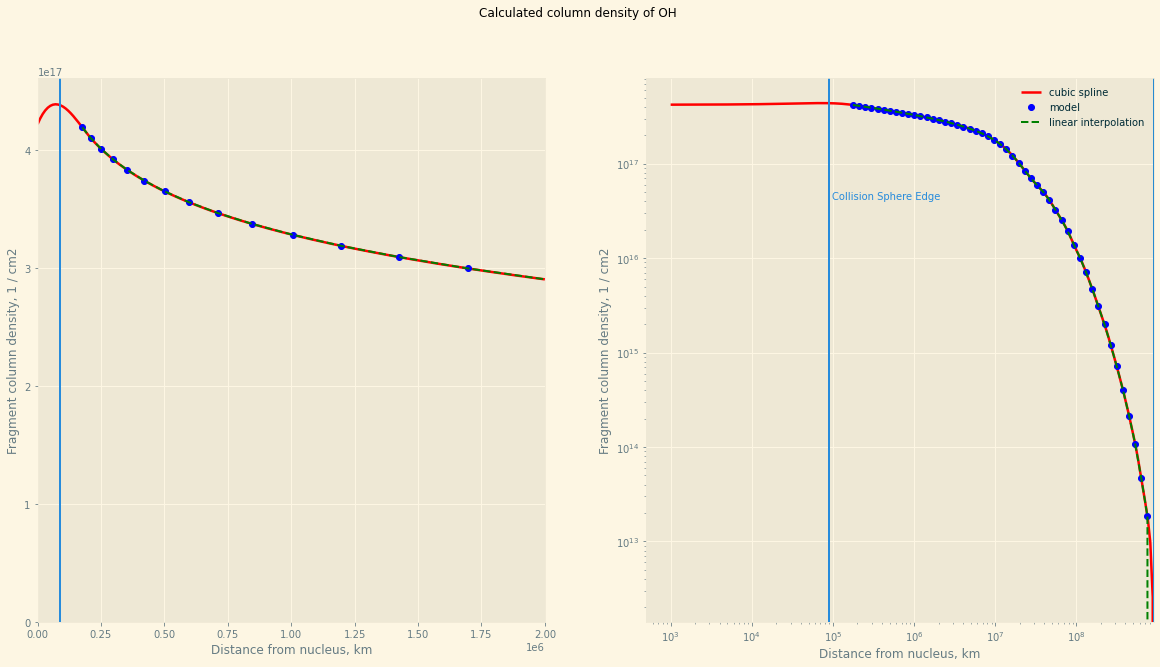

In [8]:
solarbluecol = np.array([38, 139, 220]) / 255.
solarblue = (solarbluecol[0], solarbluecol[1], solarbluecol[2], 1)
solargreencol = np.array([133, 153, 0]) / 255.
solargreen = (solargreencol[0], solargreencol[1], solargreencol[2], 1)
solarblackcol = np.array([0, 43, 54]) / 255.
solarblack = (solarblackcol[0], solarblackcol[1], solarblackcol[2], 1)

def show_column_density_plots(coma, r_units, cd_units, frag_name):
    """ Show the radial density of the fragment species """

    x_min_logplot = 3
    x_max_logplot = 9

    x_min_linear = (0 * u.km).to(u.m)
    x_max_linear = (2000 * u.km).to(u.m)

    lin_interp_x = np.linspace(x_min_linear.value, x_max_linear.value, num=200)
    lin_interp_y = coma.vmodel['column_density_interpolation'](lin_interp_x)/(u.m**2)
    lin_interp_x *= u.m
    lin_interp_x.to(r_units)

    log_interp_x = np.logspace(x_min_logplot, x_max_logplot, num=200)
    log_interp_y = coma.vmodel['column_density_interpolation'](log_interp_x)/(u.m**2)
    log_interp_x *= u.m
    log_interp_x.to(r_units)

    plt.style.use('Solarize_Light2')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.set(xlabel=f'Distance from nucleus, {r_units.to_string()}')
    ax1.set(ylabel=f"Fragment column density, {cd_units.unit.to_string()}")
    ax2.set(xlabel=f'Distance from nucleus, {r_units.to_string()}')
    ax2.set(ylabel=f"Fragment column density, {cd_units.unit.to_string()}")
    fig.suptitle(f"Calculated column density of {frag_name}")

    ax1.set_xlim([x_min_linear, x_max_linear])
    ax1.plot(lin_interp_x, lin_interp_y, color="red",  linewidth=2.5, linestyle="-", label="cubic spline")
    ax1.plot(coma.vmodel['column_density_grid'], coma.vmodel['column_densities'], 'bo', label="model")
    ax1.plot(coma.vmodel['column_density_grid'], coma.vmodel['column_densities'], 'g--', label="linear interpolation")

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.loglog(log_interp_x, log_interp_y, color="red",  linewidth=2.5, linestyle="-", label="cubic spline")
    ax2.loglog(coma.vmodel['column_density_grid'], coma.vmodel['column_densities'], 'bo', label="model")
    ax2.loglog(coma.vmodel['column_density_grid'], coma.vmodel['column_densities'], 'g--', label="linear interpolation")

    ax1.set_ylim(bottom=0)

    ax2.set_xlim(right=coma.vmodel['max_grid_radius'])

    # Mark the beginning of the collision sphere
    ax1.axvline(x=coma.vmodel['collision_sphere_radius'], color=solarblue)
    ax2.axvline(x=coma.vmodel['collision_sphere_radius'], color=solarblue)

    # Only plot as far as the maximum radius of our grid on log-log plot
    ax2.axvline(x=coma.vmodel['max_grid_radius'])

    # Mark the collision sphere
    plt.text(coma.vmodel['collision_sphere_radius']*1.1, lin_interp_y[0]/10, 'Collision Sphere Edge', color=solarblue)

    legend = plt.legend(loc='upper right', frameon=False)
    for l_text in legend.get_texts():
        l_text.set_color(solarblack)
    plt.show()


# for graphing with astropy units
quantity_support()
show_column_density_plots(coma_sine, u.km, 1/u.cm**2, 'OH')



### 3D plot of the interpolated column density

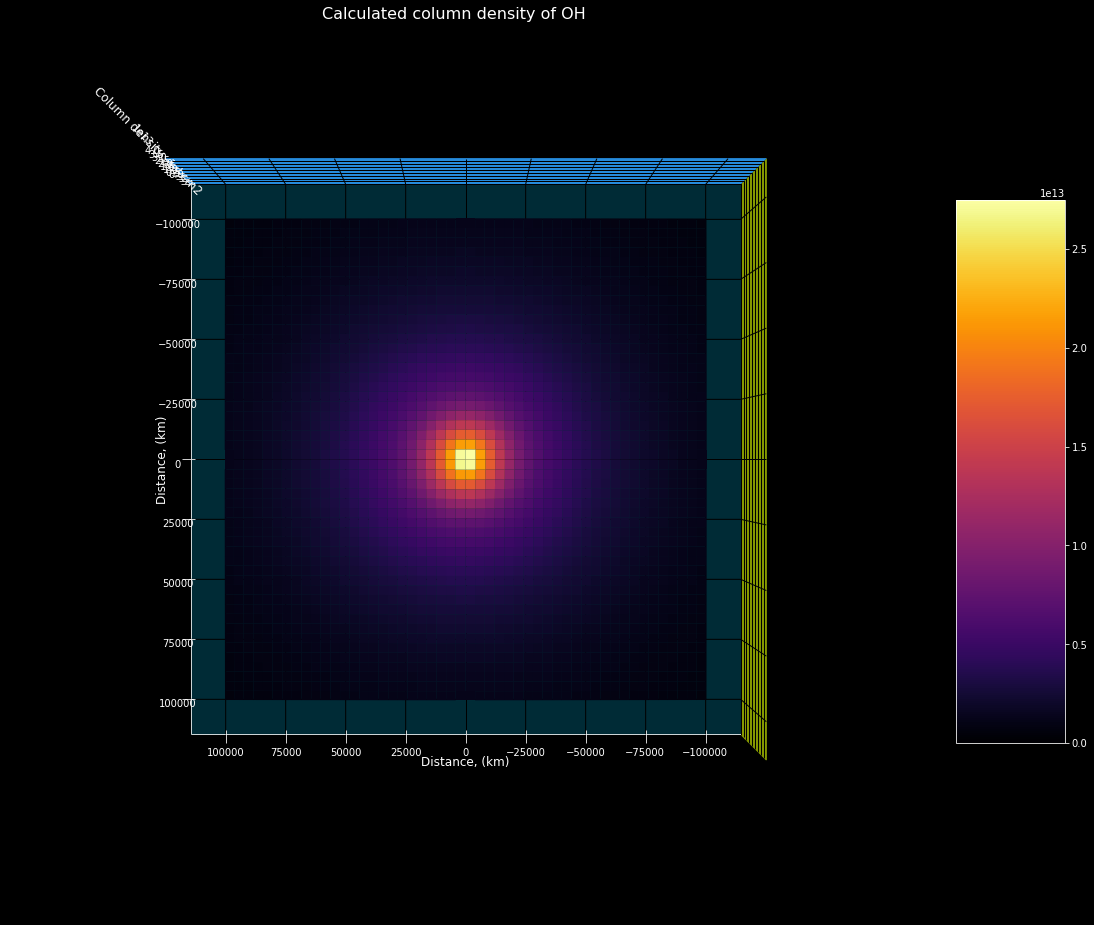

In [9]:
def show_3d_column_density_plot(coma, x_min, x_max, y_min, y_max, grid_step_x, grid_step_y, r_units, cd_units, frag_name):
    """ 3D plot of column density """

    x = np.linspace(x_min.to(u.m).value, x_max.to(u.m).value, grid_step_x)
    y = np.linspace(y_min.to(u.m).value, y_max.to(u.m).value, grid_step_y)
    xv, yv = np.meshgrid(x, y)
    z = coma.vmodel['column_density_interpolation'](np.sqrt(xv**2 + yv**2))
    # column_density_interpolation spits out m^-2
    fz = (z/u.m**2).to(cd_units)

    xu = np.linspace(x_min.to(r_units), x_max.to(r_units), grid_step_x)
    yu = np.linspace(y_min.to(r_units), y_max.to(r_units), grid_step_y)
    xvu, yvu = np.meshgrid(xu, yu)

    plt.style.use('Solarize_Light2')
    plt.style.use('dark_background')
    plt.rcParams['grid.color'] = "black"

    fig = plt.figure(figsize=(20, 20))
    ax = plt.axes(projection='3d')
    # ax.grid(False)
    surf = ax.plot_surface(xvu, yvu, fz, cmap='inferno', vmin=0, edgecolor='none')

    plt.gca().set_zlim(bottom=0)

    ax.set_xlabel(f'Distance, ({r_units.to_string()})')
    ax.set_ylabel(f'Distance, ({r_units.to_string()})')
    ax.set_zlabel(f"Column density, {cd_units.unit.to_string()}")
    plt.title(f"Calculated column density of {frag_name}")

    ax.w_xaxis.set_pane_color(solargreen)
    ax.w_yaxis.set_pane_color(solarblue)
    ax.w_zaxis.set_pane_color(solarblack)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(90, 90)
    plt.show()


show_3d_column_density_plot(coma_sine, -100000*u.km, 100000*u.km, -100000*u.km, 100000*u.km, 1000, 1000, u.km, 1/u.cm**2, 'OH')

### Obtaining total counts of fragments within apertures
The model is compatible with any sbpy aperture for obtaining total counts of fragments:

In [11]:
print("Number of fragments in")
# Set rectangular aperture to be the size of the entire grid
ap1 = sba.RectangularAperture((coma_sine.vmodel['max_grid_radius'].value, 
                               coma_sine.vmodel['max_grid_radius'].value) * u.m)
print("\tLarge rectangular aperture: ", coma_sine.total_number(ap1))

# One more time with a circular aperture
ap2 = sba.CircularAperture((coma_sine.vmodel['max_grid_radius'].value) * u.m)
print("\tLarge circular aperture: ", coma_sine.total_number(ap2))

Number of fragments in
	Large rectangular aperture:  1.9456948716998955e+33
	Large circular aperture:  2.008412781839869e+33


The model's data is stored as a function of radial distance from the nucleus, so the circular aperture is generally more trustworthy with its results.

### Optional parameters to the model

Beyond the production and time dependence, the following can be passed to VectorialModel to tweak its behavior:

radial_points (int): Number of grid points to use for the radial density grids, both volume and column density

radial_substeps (int): Controls how much each grid point will slice up the density-contributing sections of the coma

angular_points (int): Number of angular slices to take around the coma

angular_substeps (int): Controls the angular slicing of the density-contributing sections of the coma

parent_destruction_level (float): Percentage of parent molecules that will be destroyed before the grid gets cut off

fragment_destruction_level (float): Similar but for fragments

max_fragment_lifetimes (float): If a fragment has to travel farther than this many lifetimes to contribute to the density at another point in the coma, we ignore it entirely

print_progess (bool): This will periodically print out progress while calculating fragment density